<div style="font-size:16pt" font-weight="bold">Dogs vs. Cats, Keras CNN with transfer learning (Inception V3)</div><br>
<br> The structure of this notebook:
<ol>
<li>Create a model by transfer learning
<li>Load the dataset from kaggle
<li>Split the dataset into training set and validation set
<li>See sample images
<li>Data Augmentation
<li>Training
<li>Prediction
</ol>
<br>
Reference:<br> Thie code of this notebook is inspired by <a href ="https://www.coursera.org/specializations/tensorflow-in-practice"> TensorFlow in Practice Specialization</a>.<br> The theoretical background is explained in <a href="https://www.coursera.org/specializations/deep-learning"> Deep Learning Specialization</a>. The lecuture videos are also available on <a href="https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w">youtube</a>. Both are offered by deeplearning.ai

In [0]:
# Open this notebook on google colab
# Change runtime type to GPU
# In December 2019, tensorflow 2.0 is only available in google colab 
# ! pip install tensorflow==2.0.0

In [1]:
# Import the relevant libraries
import os
import json
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from shutil import copyfile

print(tf.__version__)

2.0.0


Using TensorFlow backend.


<hr>

<div style="font-size:14pt" font-weight="bold">Step 1. Create a model by transfer learning</div><br>
Transfer learning is a technique to use parameters of a pre-trained model. In image classification, there are many models pre-trained on <a href = "http://www.image-net.org/"> ImageNet</a>.  ImageNet is a database of images which has more than 14 million images with 20,000 categories. Several models including ResNet50 and InceptionV3 are available in <a href="https://keras.io/applications/"> keras</a>. <br>
For theortical background of CNN(convolutional neural network) and transfer learninng, deeplearning.ai lecture videos by professor Andrew Ng are very helpful.
Please find lecture #1-20 in the <a href = "https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF"> link </a>. 

In [3]:
# Import the inception V3 model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Clear any exiting model
tf.keras.backend.clear_session()

pre_trained_model = InceptionV3(input_shape = (150,150,3), # reshape images to 150 by 150 by 3 channels
                                include_top = False, # get straight to the CNN layer
                                weights = 'imagenet') # use the builed-in weight pre-trained on imagent

# Make all the layers in the pre-trained model non-trainable/frozen
for layer in pre_trained_model.layers:
  layer.trainable = False

87916544/87910968 [==============================] - 7s 0us/step


In [4]:
# Print the InceptionV3 model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
# Pick one layer from the miffde of the model
# We well build new dense layers after this layer

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Define a Callback class that stops training once accuracy reaches a threshold

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.875):
      print("\nReached 87.5% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Add layers after the picked last_layer
# Note that the layers below are trainable. 
# On the other hand, the layers up to the last_output is fronzen and non-trainable.

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for binary classification
x = layers.Dense(1, activation='sigmoid')(x)           

# instantiate a new model 
model = Model(pre_trained_model.input ,x) 

# Compile a model
model.compile(optimizer = RMSprop(lr=0.0001),  # We use RMSprop in this case
              loss = 'binary_crossentropy',  # cats vs. dogs is a binary problem
              metrics = ['acc']) # 'acc' stands for accuracy

# See the summary of the model 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
______________________________________________________________________________________________

Droptout: please find lecture #6 in the <a href = "https://www.youtube.com/watch?v=D8PJAL-MZv8&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=7&t=0s"> link </a>.<br>
RMSProp:  lecture #21 in the <a href = "https://www.youtube.com/watch?v=_e-LFe_igno&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=22&t=0s"> link </a>.

So far, the model has learned nothing from the Dogs vs. Cats dataset. 
<hr>

<div style="font-size:14pt" font-weight="bold">Step2. Load the dataset from kaggle</div><br> 

In [0]:
# Login to kaggle 
# Join the competition where the data are stored
# Go to My account and click "Create new API Token" 
# A json file will be downloaded. It can be opened in any text file
# Set your kaggle username and key in the dictionary below 
api_token = {"username":"your_username","key":"your_key"}

In [0]:
# Create a .kaggle　directory in the root directory 
try:
    os.mkdir("/root/.kaggle/")
except:
    pass

In [0]:
# Create a json file which stores the api keys
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [0]:
# Set owner permission to the json file 
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Delete the directory we will create if it already exists
try:
    shutil.rmtree("/tmp/cat_or_dog/")    
except:
    pass

# Create a new directory for the dataset
try:
    os.mkdir("/tmp/cat_or_dog/")
except:
    pass

In [10]:
# Go to the data tab in the kaggle competition and copy the command  
# After -p is the directory to store the data
! kaggle competitions download -c dogs-vs-cats -p /tmp/cat_or_dog/ 

 98% 535M/543M [00:11<00:00, 56.9MB/s]
100% 543M/543M [00:11<00:00, 50.6MB/s]
 98% 265M/271M [00:09<00:00, 53.5MB/s]
100% 271M/271M [00:09<00:00, 31.1MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 85.2MB/s]


In [0]:
# Unzip　the training data
local_zip = '/tmp/cat_or_dog/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cat_or_dog')
zip_ref.close()

In [12]:
# Cats and dogs images are stored in the same dirctory
# print(os.listdir('/tmp/cat_or_dog'))
# print(os.listdir('/tmp/cat_or_dog/train'))
files_list = os.listdir('/tmp/cat_or_dog/train')

['train', 'sampleSubmission.csv', 'train.zip', 'test1.zip']
['dog.11642.jpg', 'cat.3292.jpg', 'cat.4147.jpg', 'dog.9444.jpg', 'cat.2017.jpg', 'dog.240.jpg', 'dog.11900.jpg', 'cat.4091.jpg', 'dog.6672.jpg', 'cat.3118.jpg', 'dog.6236.jpg', 'dog.8841.jpg', 'cat.2654.jpg', 'cat.2613.jpg', 'dog.3955.jpg', 'cat.449.jpg', 'cat.1136.jpg', 'cat.4160.jpg', 'cat.6012.jpg', 'dog.8451.jpg', 'dog.1374.jpg', 'dog.3468.jpg', 'cat.11407.jpg', 'dog.568.jpg', 'dog.7872.jpg', 'dog.8022.jpg', 'cat.3411.jpg', 'cat.299.jpg', 'dog.10873.jpg', 'cat.10276.jpg', 'dog.9718.jpg', 'dog.12205.jpg', 'dog.6234.jpg', 'cat.10827.jpg', 'dog.5855.jpg', 'cat.11246.jpg', 'dog.8530.jpg', 'dog.7750.jpg', 'cat.2303.jpg', 'cat.9040.jpg', 'cat.3659.jpg', 'dog.10893.jpg', 'dog.7686.jpg', 'dog.5958.jpg', 'cat.5936.jpg', 'cat.8907.jpg', 'cat.6767.jpg', 'dog.3085.jpg', 'cat.3049.jpg', 'cat.9055.jpg', 'dog.10304.jpg', 'cat.11224.jpg', 'cat.5259.jpg', 'cat.17.jpg', 'dog.11276.jpg', 'dog.2283.jpg', 'cat.6757.jpg', 'dog.2119.jpg', 'cat.

In [0]:
# Create directories for training and validation

base_train_dir = '/tmp/cat_or_dog/training/'
base_val_dir = '/tmp/cat_or_dog/validation/'

# Delete the directory we will create if it already exists
try:
    shutil.rmtree(base_train_dir)    
except:
    pass

try:
    shutil.rmtree(base_val_dir)    
except:
    pass

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(base_train_dir, 'cats/')
train_dogs_dir = os.path.join(base_train_dir, 'dogs/')

# Directory with our validation cat/dog pictures
val_cats_dir = os.path.join(base_val_dir, 'cats/')
val_dogs_dir = os.path.join(base_val_dir, 'dogs/')


try:
    os.mkdir(base_train_dir)
    os.mkdir(base_val_dir)
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(val_cats_dir)
    os.mkdir(val_dogs_dir)  
except:
    pass

In [14]:
# When using .flow_from_directory in the generator,  the "training" directory should have sub-directories for the classes, "dogs" and "cats"
# Another option is to use .flow_from_dataframe. In this case, a dataframe with filename and corresponding categories is required. 
print(os.listdir(base_train_dir))

# Same for the "validation" directory 
print(os.listdir(base_val_dir))

['dogs', 'cats']
['dogs', 'cats']


In [16]:
# Shuffle the files before splting into training set and test set
random.seed(0)
random_files_list = random.sample(files_list,len(files_list))
# print(random_files_list)
print(len(files_list))
print(len(random_files_list))

['dog.8609.jpg', 'cat.7485.jpg', 'cat.10830.jpg', 'cat.3063.jpg', 'cat.6865.jpg', 'cat.8487.jpg', 'cat.12341.jpg', 'dog.12166.jpg', 'dog.5115.jpg', 'dog.2180.jpg', 'cat.11027.jpg', 'dog.6949.jpg', 'dog.5669.jpg', 'dog.5414.jpg', 'cat.8318.jpg', 'dog.6472.jpg', 'dog.8734.jpg', 'dog.3948.jpg', 'cat.11876.jpg', 'cat.5548.jpg', 'cat.1617.jpg', 'cat.9374.jpg', 'cat.4407.jpg', 'dog.11465.jpg', 'dog.5255.jpg', 'cat.12474.jpg', 'dog.7702.jpg', 'cat.3664.jpg', 'cat.11488.jpg', 'dog.11650.jpg', 'dog.2344.jpg', 'cat.5725.jpg', 'dog.7854.jpg', 'dog.6093.jpg', 'dog.8874.jpg', 'dog.6878.jpg', 'cat.4611.jpg', 'dog.2744.jpg', 'cat.9311.jpg', 'dog.11355.jpg', 'dog.8242.jpg', 'cat.11648.jpg', 'cat.11134.jpg', 'dog.3765.jpg', 'cat.8141.jpg', 'cat.3757.jpg', 'cat.2815.jpg', 'dog.2796.jpg', 'dog.3632.jpg', 'cat.7388.jpg', 'cat.11182.jpg', 'cat.5021.jpg', 'dog.4912.jpg', 'cat.4721.jpg', 'dog.7750.jpg', 'dog.446.jpg', 'dog.6824.jpg', 'dog.6971.jpg', 'cat.9861.jpg', 'dog.7696.jpg', 'cat.3683.jpg', 'cat.9710.j

In [17]:
# Deleat empty files
# In this dataset, there is no empty files
SOURCE = '/tmp/cat_or_dog/train/'

random_files_clean_list = []

for filename in random_files_list:
    file = os.path.join(SOURCE + filename)
    if os.path.getsize(file) > 0:
        random_files_clean_list.append(filename)
    else:
        print(filename + " is zero length, so ignoring.")

# print(random_files_clean_list)
print(len(random_files_list))
print(len(random_files_clean_list))

['dog.8609.jpg', 'cat.7485.jpg', 'cat.10830.jpg', 'cat.3063.jpg', 'cat.6865.jpg', 'cat.8487.jpg', 'cat.12341.jpg', 'dog.12166.jpg', 'dog.5115.jpg', 'dog.2180.jpg', 'cat.11027.jpg', 'dog.6949.jpg', 'dog.5669.jpg', 'dog.5414.jpg', 'cat.8318.jpg', 'dog.6472.jpg', 'dog.8734.jpg', 'dog.3948.jpg', 'cat.11876.jpg', 'cat.5548.jpg', 'cat.1617.jpg', 'cat.9374.jpg', 'cat.4407.jpg', 'dog.11465.jpg', 'dog.5255.jpg', 'cat.12474.jpg', 'dog.7702.jpg', 'cat.3664.jpg', 'cat.11488.jpg', 'dog.11650.jpg', 'dog.2344.jpg', 'cat.5725.jpg', 'dog.7854.jpg', 'dog.6093.jpg', 'dog.8874.jpg', 'dog.6878.jpg', 'cat.4611.jpg', 'dog.2744.jpg', 'cat.9311.jpg', 'dog.11355.jpg', 'dog.8242.jpg', 'cat.11648.jpg', 'cat.11134.jpg', 'dog.3765.jpg', 'cat.8141.jpg', 'cat.3757.jpg', 'cat.2815.jpg', 'dog.2796.jpg', 'dog.3632.jpg', 'cat.7388.jpg', 'cat.11182.jpg', 'cat.5021.jpg', 'dog.4912.jpg', 'cat.4721.jpg', 'dog.7750.jpg', 'dog.446.jpg', 'dog.6824.jpg', 'dog.6971.jpg', 'cat.9861.jpg', 'dog.7696.jpg', 'cat.3683.jpg', 'cat.9710.j

<hr>

<div style="font-size:14pt" font-weight="bold">Step 3. Split the dataset into training set and validation set</div><br> 
For details about training set and validation set, please find Andrew Ng's lecture #1 in the <a href = "https://www.youtube.com/watch?v=1waHlpKiNyY&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2&t=8s"> link</a>, or #5 in the <a href = "https://www.youtube.com/watch?v=M3qpIzy4MQk&list=PLkDaE6sCZn6E7jZ9sN_xHwSHOdjUxUW_b&index=6&t=0s"> link</a>.

In [18]:
# Split the files into training set and validation set

# Set the ratio for validation set
val_ratio = 0.3 

training_list = random_files_clean_list[:int(len(random_files_clean_list)*(1 - val_ratio))]
val_list = random_files_clean_list[-int(len(random_files_clean_list)*(val_ratio)):]

print(len(training_list))
print(len(val_list))
print(len(training_list) + len(val_list))

17500
7500
25000


In [0]:
# Create the training set

SOURCE = '/tmp/cat_or_dog/train/' # the current directory where files are stored

for filename in training_list:
    this_file = os.path.join(SOURCE + filename)
    cat_destination = os.path.join(train_cats_dir + filename)
    dog_destination = os.path.join(train_dogs_dir + filename)
    if 'cat' in filename:
        copyfile(this_file, cat_destination)
    elif 'dog' in filename:
        copyfile(this_file, dog_destination)

In [20]:
train_dog_fnames = os.listdir(train_dogs_dir)
train_cat_fnames = os.listdir(train_cats_dir)


# print(os.listdir(train_cats_dir))
# print(os.listdir(train_dogs_dir))
print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(train_dogs_dir)))

['cat.3292.jpg', 'cat.4147.jpg', 'cat.2017.jpg', 'cat.4091.jpg', 'cat.2654.jpg', 'cat.2613.jpg', 'cat.449.jpg', 'cat.1136.jpg', 'cat.6012.jpg', 'cat.11407.jpg', 'cat.3411.jpg', 'cat.10827.jpg', 'cat.11246.jpg', 'cat.2303.jpg', 'cat.9040.jpg', 'cat.3659.jpg', 'cat.5936.jpg', 'cat.8907.jpg', 'cat.6767.jpg', 'cat.3049.jpg', 'cat.9055.jpg', 'cat.11224.jpg', 'cat.5259.jpg', 'cat.17.jpg', 'cat.6757.jpg', 'cat.3532.jpg', 'cat.5508.jpg', 'cat.5552.jpg', 'cat.4122.jpg', 'cat.7247.jpg', 'cat.1983.jpg', 'cat.3122.jpg', 'cat.7129.jpg', 'cat.3099.jpg', 'cat.2102.jpg', 'cat.11895.jpg', 'cat.10569.jpg', 'cat.2663.jpg', 'cat.3600.jpg', 'cat.7012.jpg', 'cat.6378.jpg', 'cat.6178.jpg', 'cat.835.jpg', 'cat.11770.jpg', 'cat.177.jpg', 'cat.27.jpg', 'cat.4570.jpg', 'cat.1124.jpg', 'cat.4897.jpg', 'cat.5202.jpg', 'cat.3038.jpg', 'cat.3219.jpg', 'cat.1861.jpg', 'cat.35.jpg', 'cat.4653.jpg', 'cat.1133.jpg', 'cat.5608.jpg', 'cat.1926.jpg', 'cat.729.jpg', 'cat.5115.jpg', 'cat.3603.jpg', 'cat.11626.jpg', 'cat.199.

In [0]:
# Create the validation set

SOURCE = '/tmp/cat_or_dog/train/' # the current directory where files are stored

for filename in val_list:
    this_file = os.path.join(SOURCE + filename)
    cat_destination = os.path.join(val_cats_dir + filename)
    dog_destination = os.path.join(val_dogs_dir + filename)

    
    if 'cat' in filename:
        copyfile(this_file, cat_destination)
    elif 'dog' in filename:
        copyfile(this_file, dog_destination)

In [22]:
# print(os.listdir(val_cats_dir))
# print(os.listdir(val_dogs_dir))
print(len(os.listdir(val_cats_dir)))
print(len(os.listdir(val_dogs_dir)))

['cat.3118.jpg', 'cat.4160.jpg', 'cat.299.jpg', 'cat.10276.jpg', 'cat.370.jpg', 'cat.10735.jpg', 'cat.8794.jpg', 'cat.12096.jpg', 'cat.6292.jpg', 'cat.8870.jpg', 'cat.11254.jpg', 'cat.7148.jpg', 'cat.819.jpg', 'cat.10969.jpg', 'cat.687.jpg', 'cat.8474.jpg', 'cat.9579.jpg', 'cat.3085.jpg', 'cat.10342.jpg', 'cat.2582.jpg', 'cat.6348.jpg', 'cat.10938.jpg', 'cat.2276.jpg', 'cat.2518.jpg', 'cat.3959.jpg', 'cat.0.jpg', 'cat.6973.jpg', 'cat.1034.jpg', 'cat.7433.jpg', 'cat.9073.jpg', 'cat.5231.jpg', 'cat.7637.jpg', 'cat.10184.jpg', 'cat.1371.jpg', 'cat.8142.jpg', 'cat.10756.jpg', 'cat.9604.jpg', 'cat.4748.jpg', 'cat.7751.jpg', 'cat.2128.jpg', 'cat.10173.jpg', 'cat.800.jpg', 'cat.7071.jpg', 'cat.11028.jpg', 'cat.9361.jpg', 'cat.1931.jpg', 'cat.9296.jpg', 'cat.9511.jpg', 'cat.7432.jpg', 'cat.11117.jpg', 'cat.8012.jpg', 'cat.8753.jpg', 'cat.4130.jpg', 'cat.8273.jpg', 'cat.1659.jpg', 'cat.7380.jpg', 'cat.7664.jpg', 'cat.2604.jpg', 'cat.8008.jpg', 'cat.9241.jpg', 'cat.6040.jpg', 'cat.9815.jpg', 'ca

<hr>

<div style="font-size:14pt" font-weight="bold">Step 4. See sample images</div><br>

In [0]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

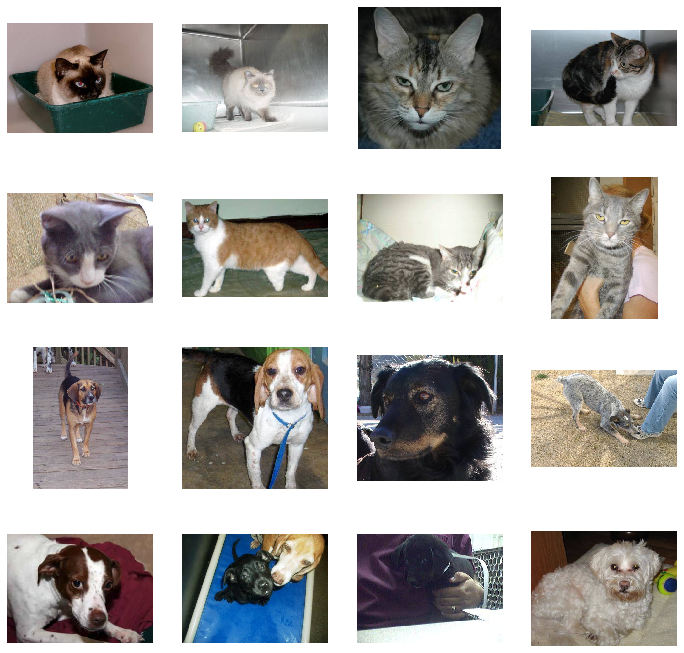

In [0]:
# Set up matplotlib fig, and size it to fit 4x4 pics
# The 8 images on the upper half are dogs, others are cats 
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

<hr>

<div style="font-size:14pt" font-weight="bold">Step 5. Data Augmentation</div><br>
Data augmentation is a technique to artifically create training data. It rotates, shifts, zooms, shears, or horizontally flips the training images. In keras ImageDataGenerator class, the original images are unchaged. It just implements data augmentation when they are feeded into the training/fitting.
For details, please find Andrew Ng's lecture #21 in the <a href = "https://www.youtube.com/watch?v=JI8saFjK84o&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=22&t=0s"> link </a>.

In [23]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., # rescale the images within 0-1. This yield better results when handling images. 
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(base_train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(base_val_dir,
                                                         batch_size = 20,
                                                         class_mode = 'binary',
                                                         target_size = (150,150))

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [26]:
# See the indices of the classes
# In keras ImageDataGenerator class, classes are indexed in alphabetical order
train_generator.class_indices

{'cats': 0, 'dogs': 1}

<hr>

<div style="font-size:14pt" font-weight="bold">Step 6. Training</div><br>
When implementing training, it is very important to understand the concept of bias/underfitting and variance/overfitting. When a model has high bias, it has low performance both on the training set and the validation set. If the model has high variance, the model performs very well on the training set but has low performance on the validation set. <br><br>When the model is underfitting, there are two solutions among others. One way is to do more training or train on more epochs. If it still not work well, we have to change the model architecture. For example, if the target objects are not in the center of the images, neural networks without convolutional layers tend to have poor performance (high bias). In that case, CNN is a better choice.  <br><br>
When the model is overfitting, there are muliple choices. Regularization/add penalties, drop out, or training on fewer epochs are among them. Data augmentation is also a way to reduce overfitting. <br><br>
Bias and Variance: Please find Andrew Ng's lecture #2 in the <a href="https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2">link</a>.<br>


In [0]:
# Fit the model the training data
# Take the log of the training in history
callbacks = myCallback()
history = model.fit_generator(
    generator = train_generator, # feed the training data via the generator
    steps_per_epoch = 8, # this is the batch size. parameters are updated per this batch size
    epochs = 100, # number of cycles. In one epoch, the whole dataset is used once.
    verbose = 2, # print out the logs
    callbacks = [callbacks], # use callbacks we set before
    validation_data = validation_generator, # feed the validation data via the generator
    validation_steps = 50 
)

Epoch 1/100
8/8 - 58s - loss: 0.9712 - acc: 0.5562 - val_loss: 0.3168 - val_acc: 0.8610
Epoch 2/100
8/8 - 53s - loss: 0.6056 - acc: 0.6812 - val_loss: 0.5841 - val_acc: 0.7290
Epoch 3/100
8/8 - 53s - loss: 0.5628 - acc: 0.7250 - val_loss: 0.4504 - val_acc: 0.8210
Epoch 4/100
8/8 - 52s - loss: 0.5374 - acc: 0.7375 - val_loss: 0.5778 - val_acc: 0.7990
Epoch 5/100
8/8 - 53s - loss: 0.5256 - acc: 0.7688 - val_loss: 0.1377 - val_acc: 0.9420
Epoch 6/100
8/8 - 54s - loss: 0.4380 - acc: 0.8125 - val_loss: 0.3660 - val_acc: 0.8750
Epoch 7/100
8/8 - 53s - loss: 0.4018 - acc: 0.8000 - val_loss: 0.4158 - val_acc: 0.8650
Epoch 8/100
8/8 - 53s - loss: 0.4142 - acc: 0.8250 - val_loss: 0.1600 - val_acc: 0.9330
Epoch 9/100
8/8 - 53s - loss: 0.4886 - acc: 0.7812 - val_loss: 0.2135 - val_acc: 0.9320
Epoch 10/100
8/8 - 53s - loss: 0.4637 - acc: 0.7750 - val_loss: 0.4213 - val_acc: 0.8810
Epoch 11/100
8/8 - 53s - loss: 0.5023 - acc: 0.7625 - val_loss: 0.1994 - val_acc: 0.9370
Epoch 12/100
8/8 - 53s - loss:

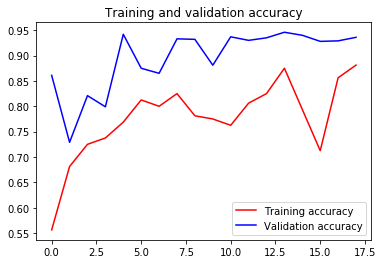

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot the accuracy history 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<hr>

<div style="font-size:14pt" font-weight="bold">Step 7. Prediction</div><br>
Prediction of the unlabeled test set images is the final stage. 

In [0]:
# Unzip　the test data
local_zip = '/tmp/cat_or_dog/test1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cat_or_dog')
zip_ref.close()

In [0]:
base_test_dir = '/tmp/cat_or_dog/test1/'

# print(os.listdir(base_test_dir))

['12200.jpg', '7209.jpg', '2620.jpg', '9457.jpg', '8185.jpg', '1870.jpg', '3705.jpg', '9672.jpg', '11771.jpg', '4434.jpg', '5659.jpg', '10007.jpg', '11469.jpg', '2150.jpg', '7960.jpg', '2075.jpg', '9716.jpg', '6536.jpg', '7881.jpg', '8211.jpg', '747.jpg', '7756.jpg', '8743.jpg', '4259.jpg', '1254.jpg', '1580.jpg', '236.jpg', '6029.jpg', '5798.jpg', '5421.jpg', '3696.jpg', '6657.jpg', '7649.jpg', '2180.jpg', '7216.jpg', '10113.jpg', '11795.jpg', '12210.jpg', '11342.jpg', '4572.jpg', '6407.jpg', '5925.jpg', '4688.jpg', '7457.jpg', '9176.jpg', '2806.jpg', '2006.jpg', '9682.jpg', '1484.jpg', '6060.jpg', '9016.jpg', '6716.jpg', '12353.jpg', '9572.jpg', '2409.jpg', '11855.jpg', '3202.jpg', '10246.jpg', '8677.jpg', '8714.jpg', '9382.jpg', '1722.jpg', '6557.jpg', '11270.jpg', '3082.jpg', '6824.jpg', '5131.jpg', '6774.jpg', '4861.jpg', '3856.jpg', '1439.jpg', '2437.jpg', '79.jpg', '8665.jpg', '1105.jpg', '11065.jpg', '1230.jpg', '2345.jpg', '3949.jpg', '7889.jpg', '9325.jpg', '8262.jpg', '6724.

In [0]:
# To use .flow_from_dataframe. in the generator, we have to create a dataframe  
test_filenames = os.listdir(base_test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [0]:
# Create a generator for test set
test_gen = ImageDataGenerator(rescale=1./255.0)
batch_size=20

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    base_test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(150, 150),
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
# Predict the test set
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0) # we can also 

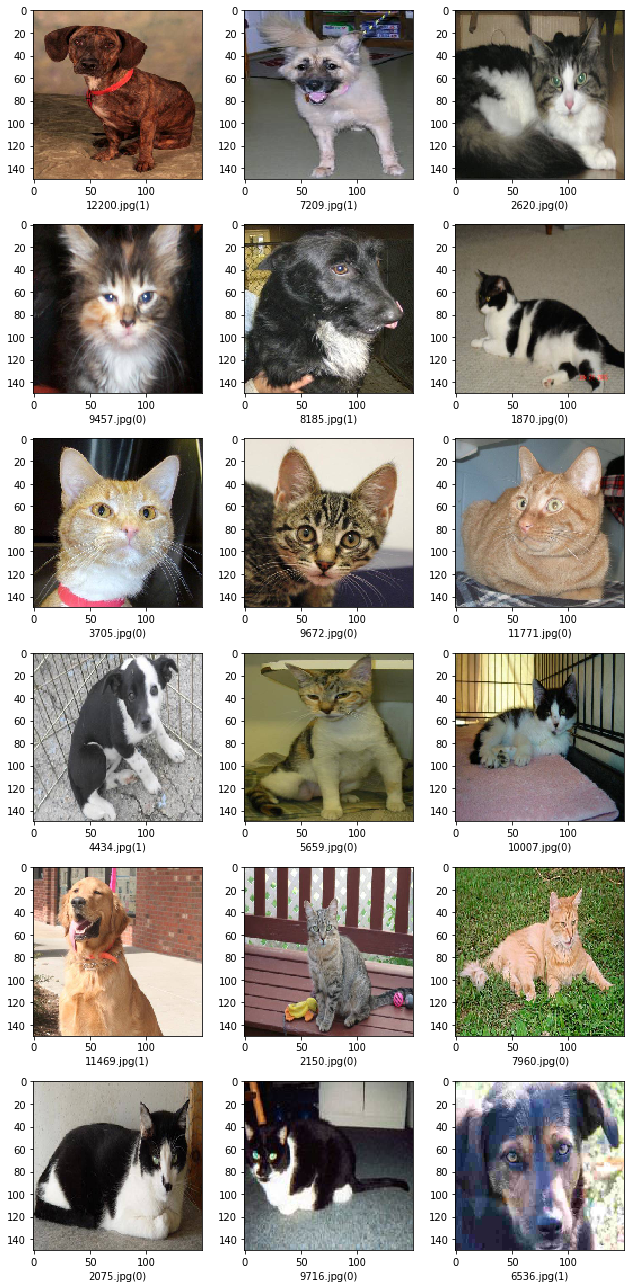

In [0]:
# See sample results, # 1 = dog, 0 = cat
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(9, 18))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(base_test_dir+filename, target_size=(150,150))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' ) 
plt.tight_layout()
plt.show()

<div style="font-size:14pt" font-weight="bold">Submit</div><br>
<br>
Note that we cannot submit past competiton.

In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('/tmp/cat_or_dog/submission_20191230.csv', index=False)

In [0]:
!  kaggle competitions submit -c dogs-vs-cats -f /tmp/cat_or_dog/ submission_20191229.csv -m "First submission"

Could not find competition - please verify that you entered the correct competition ID and that the competition is still accepting submissions.
